In [ ]:
# Downloading all codes & dependencies
!git clone https://github.com/ZhengPeng7/BiRefNet.git
!pip uninstall -q torchaudio torchdata torchtext -y
!pip install -q -r BiRefNet/requirements.txt
!pip install -q -U gdown
# Download a sample image in very high resolution
!gdown 1DGBe63XrwwSutS84FrrrjDga3BiuQsRc
# Download weights locally
!wget https://github.com/ZhengPeng7/BiRefNet/releases/download/v1/BiRefNet-general-epoch_244.pth
%cd BiRefNet

In [ ]:
# Imports
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display

from models.birefnet import BiRefNet


# # Option 1: loading BiRefNet with weights:
# from transformers import AutoModelForImageSegmentation
# birefnet = AutoModelForImageSegmentation.from_pretrained('zhengpeng7/BiRefNet', trust_remote_code=True)

# # Option-2: loading weights with BiReNet codes:
# birefnet = BiRefNet.from_pretrained('zhengpeng7/BiRefNet')

# Option-3: Loading model and weights from local disk:
from utils import check_state_dict

birefnet = BiRefNet(bb_pretrained=False)
state_dict = torch.load('../BiRefNet-general-epoch_244.pth', map_location='cpu')
state_dict = check_state_dict(state_dict)
birefnet.load_state_dict(state_dict)


# Load Model
device = 'cuda'
torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to(device)
birefnet.eval()
print('BiRefNet is ready to use.')

# Input Data
transform_image = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

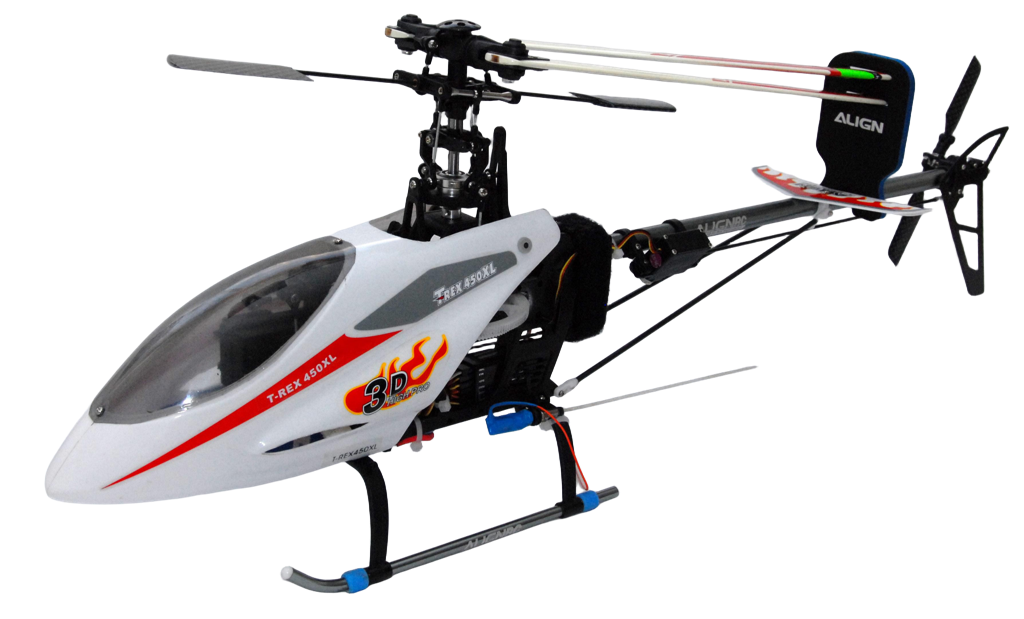

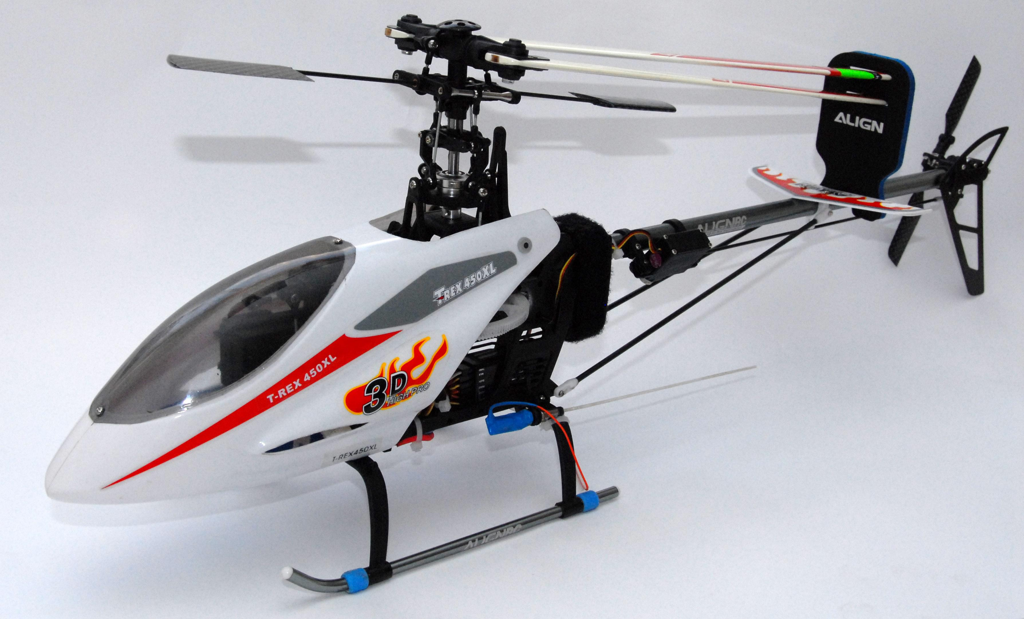

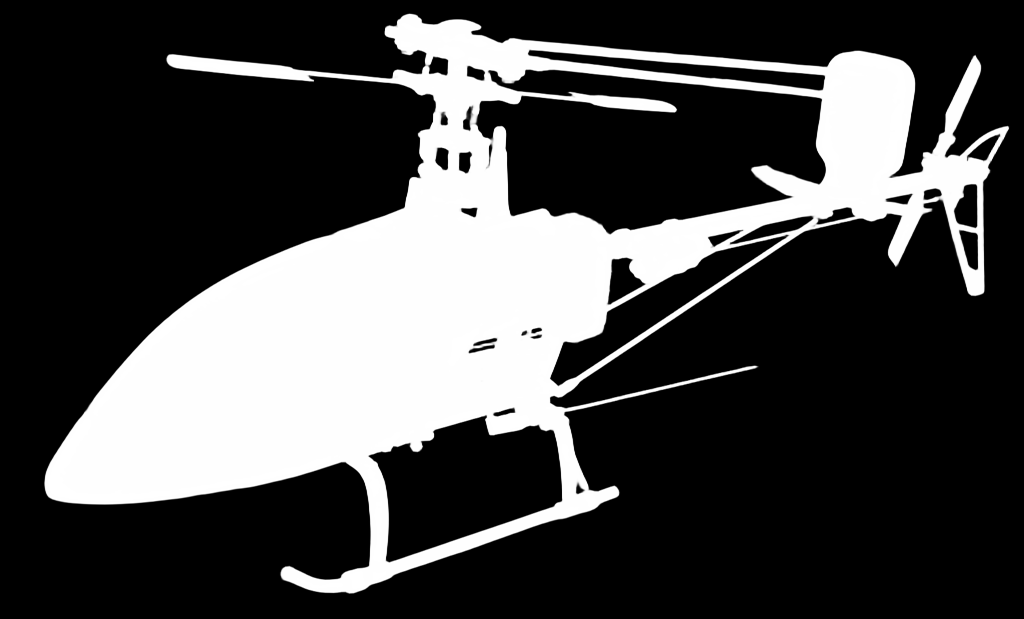

In [ ]:
imagepath = '../Helicopter-HR.jpg'
image = Image.open(imagepath)
input_images = transform_image(image).unsqueeze(0).to('cuda')

# Prediction
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# Show Results
pred_pil = transforms.ToPILImage()(pred)
# Scale proportionally with max length to 1024 for faster showing
scale_ratio = 1024 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))
image_masked = image.resize((1024, 1024))
image_masked.putalpha(pred_pil)
display(image_masked.resize(scaled_size))
display(image.resize(scaled_size))
display(pred_pil.resize(scaled_size))

In [ ]:
# import requests
# from io import BytesIO


# image_url = "https://qph.cf2.quoracdn.net/main-qimg-d89362d538d350a4e4218a366e0d0425-pjlq"
# response = requests.get(image_url)
# image_data = BytesIO(response.content)
# image = Image.open(image_data)
# input_images = transform_image(image).unsqueeze(0).to('cuda')

# # Prediction
# with torch.no_grad():
#     preds = birefnet(input_images)[-1].sigmoid().cpu()
# pred = preds[0].squeeze()

# # Show Results
# pred_pil = transforms.ToPILImage()(pred)
# # Scale proportionally with max length to 1024 for faster showing
# scale_ratio = 1024 / max(image.size)
# scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))
# image_masked = image.resize((1024, 1024))
# image_masked.putalpha(pred_pil)
# display(image_masked.resize(scaled_size))
# display(image.resize(scaled_size))
# display(pred_pil.resize(scaled_size))

In [ ]:
# Set pretrained setting as False
with open('models/birefnet.py', 'r') as f:
    content = f.read()
with open('models/birefnet.py', 'w') as f:
    content_new = content.replace(', pretrained=True)', ', pretrained=False)')
    f.write(content_new)

# Adapt the data_root_dir and set load_all to False
with open('config.py', 'r') as f:
    content = f.read()
with open('config.py', 'w') as f:
    content_new = content.replace("self.data_root_dir = os.path.join(self.sys_home_dir, 'datasets/dis')", "self.data_root_dir = '..'")
    content_new = content_new.replace('self.load_all = True', 'self.load_all = False')
    content_new = content_new.replace('self.num_workers = 5', 'self.num_workers = 1')
    f.write(content_new)

In [ ]:
import os
from glob import glob
# Parameter from command line
class ParserTest():
    def __init__(self) -> None:
        self.ckpt = '../BiRefNet-DIS-epoch_590.pth'
        self.ckpt_folder = ''
        self.pred_root = '../e_preds'
        self.testsets = 'DIS-VD'

args_test = ParserTest()

In [ ]:
# Inference
from inference import main as inference_main

## Modify it if you want to use custom data, which should be saved in the same path as DIS-VD is.
CUSTOM_IMAGE_FOLDER = ''
for testset in 'DIS-VD+{}'.format(CUSTOM_IMAGE_FOLDER).strip('+').split('+'):
    args_test.testsets = testset
    inference_main(args_test)

In [ ]:
# Evaluation
from eval_existingOnes import do_eval
from config import Config


config = Config()

class ParserEval():
    def __init__(self) -> None:
        self.gt_root = os.path.join(config.data_root_dir, config.task)
        self.pred_root = '../e_preds'
        self.data_lst = {
            'DIS5K': '+'.join(['DIS-VD', 'DIS-TE1', 'DIS-TE2', 'DIS-TE3', 'DIS-TE4'][:1]),
            'COD': '+'.join(['COD10K', 'NC4K', 'CAMO', 'CHAMELEON'][:1]),
            'SOD': '+'.join(['DAVIS-S', 'HRSOD-TE', 'UHRSD-TE', 'DUTS-TE', 'DUT-OMRON'][:1])
        }[config.task]
        self.model_lst = [args_test.ckpt] if args_test.ckpt else sorted(glob(os.path.join(args_test.ckpt_folder, '*')))[-1]
        self.save_dir = '../e_results'
        self.metrics = '+'.join(['S', 'MAE', 'E', 'F', 'WF', 'HCE'][:2])

args_eval = ParserEval()

os.makedirs(args_eval.save_dir, exist_ok=True)
args_eval.model_lst = [m for m in sorted(os.listdir(args_eval.pred_root), key=lambda x: int(x.split('epoch_')[-1]))]

# start engine
do_eval(args_eval)

#################### DIS-VD ####################
	 Evaluating model: --BiRefNet-DIS-epoch_540...


100%|██████████| 470/470 [05:51<00:00,  1.34it/s]

+---------+--------------------------+-------+-----------+------+----------+--------+------+-------+--------+-------+-------+
& Dataset &          Method          & maxFm & wFmeasure & MAE  & Smeasure & meanEm & HCE  & maxEm & meanFm & adpEm & adpFm &
+---------+--------------------------+-------+-----------+------+----------+--------+------+-------+--------+-------+-------+
&  DIS-VD & --BiRefNet-DIS-epoch_540 &  .000 &    .000   & .038 &   .898   &  .000  & .000 &  .000 &  .000  &  .000 &  .000 &
+---------+--------------------------+-------+-----------+------+----------+--------+------+-------+--------+-------+-------+
